In [3]:
def unixifyPickle(original, destination):
    content = ''
    outsize = 0
    with open(original, 'rb') as infile:
        content = infile.read()
    with open(destination, 'wb') as output:
        for line in content.splitlines():
            outsize += len(line) + 1
            output.write(line + str.encode('\n'))

    print("Done. Saved %s bytes." % (len(content)-outsize))

In [5]:
# %load ./SourceFiles/ud120-projects/tools/feature_format.py
#!/usr/bin/python

""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm

    n--no. of key-value pairs in dictonary
    k--no. of features being extracted

    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person

    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for

    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:

    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)

    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""


import numpy as np

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features






Done. Saved 6705 bytes.


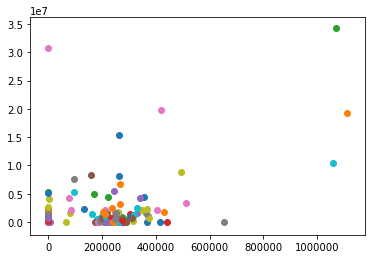

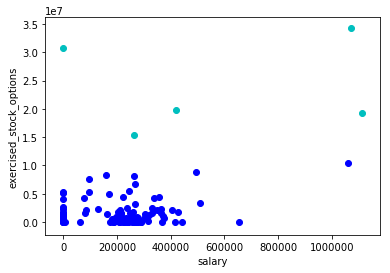

In [54]:
# %load ./SourceFiles/ud120-projects/k_means/k_means_cluster.py
#!/usr/bin/python 

""" 
    Skeleton code for k-means clustering mini-project.
"""




import pickle
import numpy
import matplotlib.pyplot as plt
import sys



def Draw(pred, features, poi, mark_poi=False, name="image.png", f1_name="feature 1", f2_name="feature 2"):
    """ some plotting code designed to help you visualize your clusters """

    ### plot each cluster with a different color--add more colors for
    ### drawing more than five clusters
    colors = ["b", "c", "k", "m", "g"]
    for ii, pp in enumerate(pred):
        plt.scatter(features[ii][0], features[ii][1], color = colors[pred[ii]])

    ### if you like, place red stars over points that are POIs (just for funsies)
    if mark_poi:
        for ii, pp in enumerate(pred):
            if poi[ii]:
                plt.scatter(features[ii][0], features[ii][1], color="r", marker="*")
    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.savefig(name)
    plt.show()



### load in the dict of dicts containing all the data on each person in the dataset
source = "./SourceFiles/ud120-projects/final_project/final_project_dataset.pkl"
destination = "./SourceFiles/ud120-projects/final_project/final_project_dataset_unix.pkl"
unixifyPickle(source, destination)

data_dict = pickle.load( open(destination, "rb") )
### there's an outlier--remove it! 
data_dict.pop("TOTAL", 0)


### the input features we want to use 
### can be any key in the person-level dictionary (salary, director_fees, etc.) 
feature_1 = "salary"
feature_2 = "exercised_stock_options"
#feature_3 = "total_payments"
poi  = "poi"
features_list = [poi, feature_1, feature_2]
data = featureFormat(data_dict, features_list )
 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rescaled_data= scaler.fit_transform(data)
#poi, finance_features = targetFeatureSplit( rescaled_data )
poi, finance_features = targetFeatureSplit( data )

### in the "clustering with 3 features" part of the mini-project,
### you'll want to change this line to 
### for f1, f2, _ in finance_features:
### (as it's currently written, the line below assumes 2 features)
for f1, f2 in finance_features:
    plt.scatter( f1, f2 )
plt.show()

### cluster here; create predictions of the cluster labels
### for the data and store them to a list called pred
from  sklearn.cluster import KMeans
pred = KMeans(n_clusters=2, random_state=0).fit_predict(finance_features)

### rename the "name" parameter when you change the number of features
### so that the figure gets saved to a different file
try:
    Draw(pred, finance_features, poi, mark_poi=False, name="clusters.pdf", f1_name=feature_1, f2_name=feature_2)
except NameError:
    print("no predictions object named pred found, no clusters to plot")


In [34]:
data_min_max = featureFormat(data_dict, ["exercised_stock_options"] )
print(min(data_min_max))
print(max(data_min_max))

[ 3285.]
[ 34348384.]


In [35]:
data_min_max = featureFormat(data_dict, ["salary"] )
print(min(data_min_max))
print(max(data_min_max))

[ 477.]
[ 1111258.]


In [48]:
### why would you rescale it?  Or even use it at all?
def featureScaling(arr):
    min_num = min(arr)
    max_num = max(arr)
    if min_num == max_num:
        return arr
    else:
        new_arr = []
        for number in arr:
            number = float((number - min_num) / (max_num - min_num))
            new_arr.append(number)
        return new_arr
    return None

# tests of your feature scaler--line below is input data
data = [115, 140, 175]
print(featureScaling(data))


[0.0, 0.4166666666666667, 1.0]


In [51]:
import numpy 
from sklearn.preprocessing import MinMaxScaler
weights = numpy.array([[115.], [140.], [175.]])
scaler = MinMaxScaler()
rescaled_weight= scaler.fit_transform(weights)
print(rescaled_weight)

[[ 0.        ]
 [ 0.41666667]
 [ 1.        ]]
